MetaData Model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets
movies = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv', low_memory=False, nrows=20000) 
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv', nrows=20000)
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv', nrows=20000)

# Preprocess the datasets
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce')

# Remove rows with NaN values in 'id' column
movies = movies.merge(credits, on='id', how='left')
movies = movies.merge(keywords, on='id', how='left')

# Drop unnecessary columns
for feature in ['cast', 'crew', 'keywords', 'genres']:
    movies[feature] = movies[feature].fillna('[]')

import ast
# Function to convert string representation of list to actual list
def parse_features(x):
    try:
        return [i['name'] for i in ast.literal_eval(x)]
    except:
        return []
# Parse the 'genres' and 'keywords' columns
movies['genres'] = movies['genres'].apply(parse_features)
movies['keywords'] = movies['keywords'].apply(parse_features)

# Parse the 'cast' column
def get_cast(x):
    try:
        return [i['name'] for i in ast.literal_eval(x)][:3]
    except:
        return []

# Get the top 3 cast members
movies['cast'] = movies['cast'].apply(get_cast)

# Parse the 'crew' column to get the director
def get_director(x):
    try:
        for i in ast.literal_eval(x):
            if i['job'] == 'Director':
                return i['name']
        return ''
    except:
        return ''

movies['director'] = movies['crew'].apply(get_director)

# Combine all features into a single string
def combine_features(row):
    return ' '.join(row['genres']) + ' ' + ' '.join(row['keywords']) + ' ' + ' '.join(row['cast']) + ' ' + row['director']

movies['combined_features'] = movies.apply(combine_features, axis=1)

# Create a count matrix from the combined features
cv = CountVectorizer(stop_words='english')
count_matrix = cv.fit_transform(movies['combined_features'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# Create a Series for movie titles and their corresponding indices
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()



Deep Rc model( based on rating) and hybrid model

In [ ]:
# Import necessary libraries for collaborative filtering
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load the ratings dataset
ratings = pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv', nrows=500000)  # 路径请根据实际情况调整
ratings = ratings[ratings['movieId'].isin(movies['id'])]

# Preprocess the ratings dataset
user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
embedding_size = 32

# Split the data into training and testing sets
x = ratings[['user', 'movie']].values
y = ratings['rating'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Build the collaborative filtering model
user_input = keras.Input(shape=(1,))
user_embedding = layers.Embedding(num_users, embedding_size)(user_input)
user_vec = layers.Flatten()(user_embedding)
# Flatten the user embedding
movie_input = keras.Input(shape=(1,))
movie_embedding = layers.Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)
movie_vec = layers.Flatten()(movie_embedding)
# Flatten the movie embedding
concat = layers.Concatenate()([user_vec, movie_vec])
dense = layers.Dense(64, activation='relu')(concat)
dense = layers.Dense(32, activation='relu')(dense)
output = layers.Dense(1)(dense)
# Create the model
model = keras.Model([user_input, movie_input], output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Train the model
model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          batch_size=256, epochs=5, 
          validation_data=([x_test[:, 0], x_test[:, 1]], y_test))

movie_emb_layer = model.get_layer('movie_embedding')
movie_embeddings = movie_emb_layer.get_weights()[0]  # shape: (num_movies, embedding_size)

# Align the content-based and collaborative filtering embeddings
content_movie_ids = set(movies['id'])
cf_movie_ids = set(movie_ids)
common_movie_ids = list(content_movie_ids & cf_movie_ids)
common_movie_ids_sorted = [mid for mid in movies['id'] if mid in common_movie_ids]

content_idx = [i for i, mid in enumerate(movies['id']) if mid in common_movie_ids]
content_embeddings_aligned = count_matrix.toarray()[content_idx]

movieid2cfidx = {mid: i for i, mid in enumerate(movie_ids)}
cf_embeddings_aligned = np.array([movie_embeddings[movieid2cfidx[mid]] for mid in common_movie_ids_sorted])

hybrid_embeddings = np.hstack([content_embeddings_aligned, cf_embeddings_aligned])
movies_aligned = movies[movies['id'].isin(common_movie_ids_sorted)].reset_index(drop=True)


from sklearn.metrics.pairwise import cosine_similarity
# Function to get hybrid recommendations
def get_hybrid_recommendations(title, top_n=10):
    idx = movies_aligned[movies_aligned['title'] == title].index
    if len(idx) == 0:
        return f"film {title}not found"
    idx = idx[0]
    target_emb = hybrid_embeddings[idx].reshape(1, -1)
    similarities = cosine_similarity(target_emb, hybrid_embeddings)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    return movies_aligned['title'].iloc[similar_indices]

# Example usage
print(get_hybrid_recommendations('Casino'))

2025-05-09 06:25:28.007357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746771928.342310      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746771928.429467      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 06:25:45.484016: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.4717 - mae: 1.3718 - val_loss: 0.7777 - val_mae: 0.6819
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7448 - mae: 0.6673 - val_loss: 0.7585 - val_mae: 0.6723
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7087 - mae: 0.6502 - val_loss: 0.7424 - val_mae: 0.6605
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6715 - mae: 0.6312 - val_loss: 0.7351 - val_mae: 0.6589
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6511 - mae: 0.6193 - val_loss: 0.7375 - val_mae: 0.6658
26              Taxi Driver
261              GoodFellas
1536           Mean Streets
272             Raging Bull
325               Cape Fear
1211     The King of Comedy
925                    Blow
859     Requiem for a Dream
682        Drugstore Cowboy
514         We're No Angels
Name: title, dtype: object


In [3]:
cf_embeddings_aligned

array([[-0.00952012,  0.00238809,  0.04954484, ...,  0.00924215,
         0.01474443,  0.05566517],
       [-0.09840345,  0.05412672, -0.00822034, ..., -0.03876671,
         0.08754002, -0.00353361],
       [-0.05161748,  0.00931444, -0.04289376, ...,  0.06445226,
        -0.03998681,  0.03198124],
       ...,
       [-0.03271378,  0.06192413,  0.09833749, ..., -0.00633373,
         0.04867793,  0.04199213],
       [ 0.00691332,  0.03181588,  0.07293497, ..., -0.0255795 ,
         0.02584528,  0.01021731],
       [ 0.06442261, -0.0722402 , -0.0163811 , ...,  0.03497859,
        -0.08697623, -0.06862516]], dtype=float32)

In [ ]:
# Define a function to get content-based recommendations
def get_content_recommendations(title, top_n=10):
    idx = movies_aligned[movies_aligned['title'] == title].index
    if len(idx) == 0:
        return f"film {title}not found"
    idx = idx[0]
    target_emb = content_embeddings_aligned[idx].reshape(1, -1)
    similarities = cosine_similarity(target_emb, content_embeddings_aligned)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    return movies_aligned['title'].iloc[similar_indices]

In [ ]:
# Define a function to get movie recommendations based on collaborative filtering
def get_movie_recommendations(title, top_n=10):
    idx = movies_aligned[movies_aligned['title'] == title].index
    if len(idx) == 0:
        return f"film {title}not found"
    idx = idx[0]
    target_emb = cf_embeddings_aligned[idx].reshape(1, -1)
    similarities = cosine_similarity(target_emb, cf_embeddings_aligned)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    return movies_aligned['title'].iloc[similar_indices]

In [ ]:
# Check the shape of the content embeddings
content_embeddings_aligned.shape

(2962, 33627)

In [ ]:
# Printing the recommendations
print(get_movie_recommendations('Toy Story'))
print('-----------------')
print(get_content_recommendations('Toy Story'))
print('-----------------')
print(get_hybrid_recommendations('Toy Story'))

2858    The Twilight Saga: Breaking Dawn - Part 1
2480                                     Twilight
1296                        The Magdalene Sisters
2203                        Breaking and Entering
178                                       Sabrina
588                                      eXistenZ
2043                        Ice Age: The Meltdown
974                                     They Live
1659                                Pandora's Box
1263                      Man with a Movie Camera
Name: title, dtype: object
-----------------
640                                Big
877        The Transformers: The Movie
2351    Mr. Magorium's Wonder Emporium
77                     The Flintstones
1384                   Only the Lonely
2801                            Cars 2
2221                Meet the Robinsons
2069                              Cars
1130               Who Is Cletis Tout?
711                       Galaxy Quest
Name: title, dtype: object
-----------------
640                 

Pca features

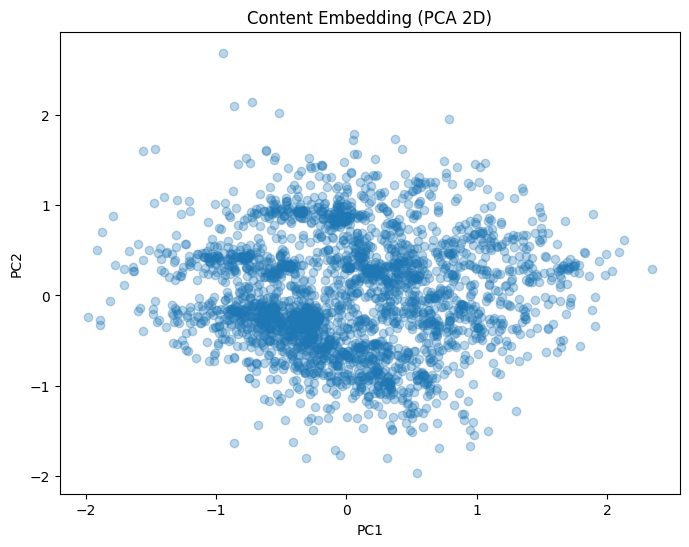

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
content_2d = pca.fit_transform(content_embeddings_aligned)

# Plotting the PCA results
plt.figure(figsize=(8,6))
plt.scatter(content_2d[:,0], content_2d[:,1], alpha=0.3)
plt.title('Content Embedding (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

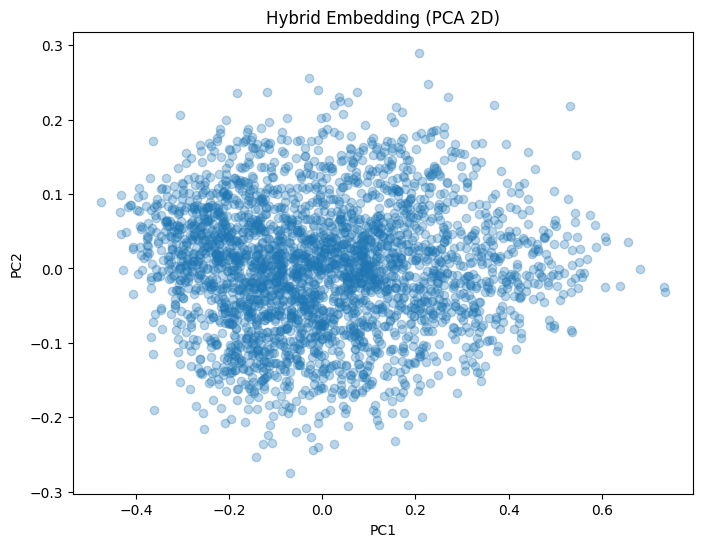

In [ ]:
pca = PCA(n_components=2)
hybrid_2d = pca.fit_transform(cf_embeddings_aligned)

# Plotting the PCA results for hybrid embeddings
plt.figure(figsize=(8,6))
plt.scatter(hybrid_2d[:,0], hybrid_2d[:,1], alpha=0.3)
plt.title('Hybrid Embedding (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

distribution

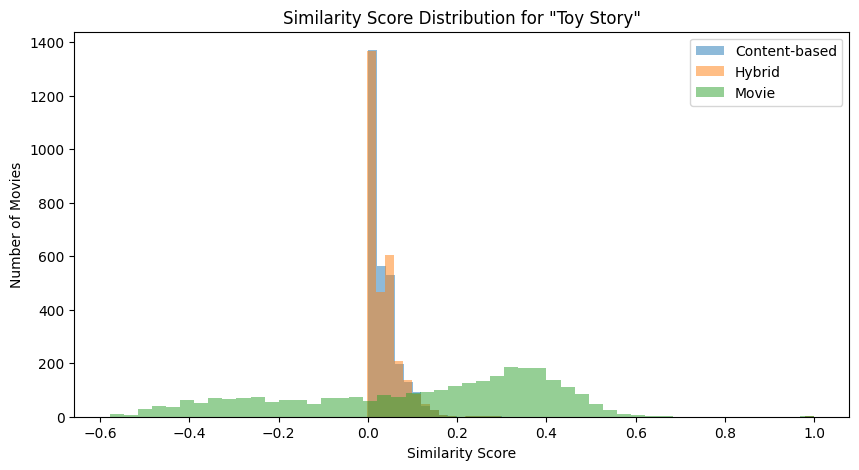

In [ ]:
import matplotlib.pyplot as plt

# Plotting the similarity score distribution for "Toy Story"
idx = movies_aligned[movies_aligned['title'] == 'Toy Story'].index[0]

content_sim = cosine_similarity(content_embeddings_aligned[idx].reshape(1, -1), content_embeddings_aligned)[0]
hybrid_sim = cosine_similarity(hybrid_embeddings[idx].reshape(1, -1), hybrid_embeddings)[0]
# Get the movie similarity scores
movie_sim = cosine_similarity(cf_embeddings_aligned[idx].reshape(1, -1), cf_embeddings_aligned)[0]
# Plotting the similarity score distribution
plt.figure(figsize=(10,5))
plt.hist(content_sim, bins=50, alpha=0.5, label='Content-based')
plt.hist(hybrid_sim, bins=50, alpha=0.5, label='Hybrid')
plt.hist(movie_sim, bins=50, alpha=0.5, label='Movie')
plt.title('Similarity Score Distribution for "Toy Story"')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Movies')
plt.legend()
plt.show()